#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [69]:
import sys

sys.path.append(
    "C:\\Users\\ilyaa\\OneDrive\\Documenten\\GitHub\\ML_course\\labs\\ex02\\template\\ex02.ipynb"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [78]:
import grid_search # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import *  # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = gs.generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [71]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE

    w=w.reshape(-1,1)
    y=y.reshape(-1,1)
   
     
    e=y-tx@w
    MSE= (1/(2*y.shape[0]))*e.T@e
      

    return MSE
    # ***************************************************

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [81]:

def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least squares: TODO
    # returns mse, and optimal weights
    w = np.linalg.solve(tx.T@tx, tx.T@y)

    mse = compute_loss(y,tx,w)

    mse=mse[0]

    return w, mse[0]
    # ***************************************************
    

### You can test your implementation here

In [82]:
test(least_squares)
# NB:
#
# Due to precision issues,
# the output might not be exactly the same
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:)

❌ The are some issues with your implementation of `least_squares`:
**********************************************************************
File "__main__", line 13, in least_squares
Failed example:
    least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
Expected:
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
Got:
    (array([ 0.21212121, -0.12121212]), 2.946672814912471e-32)
**********************************************************************


In [90]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    #n0,=grid_w0.shape
    #n1,=grid_w1.shape


    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            losses[i, j]= compute_loss(y,tx,np.array([grid_w0[i],grid_w1[j]]))
     
    # ***************************************************
    return losses

In [93]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************
    e=y-tx@w
    
    grad = -1/y.shape[0] *tx.T@e

    return grad



In [94]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss

        grad=compute_gradient(y, tx, w)
        loss=compute_loss(y, tx, w)


        w=w-gamma*grad

        # ***************************************************

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [97]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    # ***************************************************
    w_star, mse = least_squares(y, tx)
    grid_w0, grid_w1 = gs.generate_w(num_intervals=50)
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    # Select the best combinaison
    loss_star, w0_star, w1_star = gs.get_best_parameters(grid_w0, grid_w1, grid_losses) 
    print(w0_star-w_star[0])
    print(w1_star-w_star[1])
    print(loss_star-mse, '\n\n\n')  

    max_iters = 50
    gamma = 0.7

    # Initialization
    w_initial = np.array([0, 0])

    #Start gradient descent.
    gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
    print(gd_ws[-1][0]-w_star[0])
    print(gd_ws[-1][1]-w_star[1])
    print(gd_losses[-1]-mse, '\n\n\n') 
   

Test it here

In [98]:
test_your_least_squares()

-1.8653505735337745
1.8264100139905555
3.4076531506938395 



GD iter. 0/49: loss=[[2792.23671276]], w0=51.30574540147363, w1=9.435798704492283
GD iter. 1/49: loss=[[265.30246211]], w0=66.69746902191572, w1=12.26653831584
GD iter. 2/49: loss=[[37.87837955]], w0=71.31498610804834, w1=13.11576019924433
GD iter. 3/49: loss=[[17.41021212]], w0=72.70024123388814, w1=13.370526764265632
GD iter. 4/49: loss=[[15.56807705]], w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=[[15.4022849]], w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=[[15.3873636]], w0=73.27789262136332, w1=13.476764421879516
GD iter. 7/49: loss=[[15.38602068]], w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=[[15.38589982]], w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=[[15.38588894]], w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=[[15.38588797]], w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=[[15.38588788]], w0=73.293883050

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [99]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [100]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    N = len(x)
    poly = np.zeros((N, degree + 1))
    
    for n in range(N):
        for j in range(degree + 1):
            poly[n, j] = x[n] ** j
    
    return poly



In [101]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [102]:
from plots import *


def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
    and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form the data to do polynomial regression.: TODO
        # ***************************************************
        x, y = load_data()
        x_poly = build_poly(x, degree)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO
        # ***************************************************
        weights,mse= least_squares(y, x_poly)
        rmse= np.sqrt(mse)

        print(
            "Processing {i}th experiment, degree={d}, rmse={loss}".format(
                i=ind + 1, d=degree, loss=rmse
            )
        )
        # plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.3336667757890794
Processing 2th experiment, degree=3, rmse=0.18284563488661834
Processing 3th experiment, degree=7, rmse=0.17653536230421968
Processing 4th experiment, degree=12, rmse=0.17202668768375484


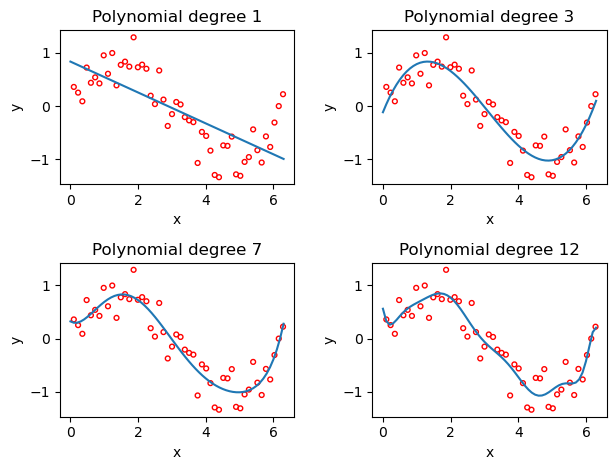

In [103]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [104]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    splitratio= int(ratio * len(x))
    indices = np.random.permutation(len(x))
    x = x[indices]
    y = y[indices]
    x_tr=x[:splitratio]
    x_te=x[splitratio:]   
    y_tr=y[:splitratio]
    y_te=y[splitratio:]

    return x_tr, x_te, y_tr, y_te

In [105]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [106]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    x_tr, x_te, y_tr, y_te=split_data(x, y, ratio, seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    x_tr_poly = build_poly(x_tr, degree)
    x_te_poly = build_poly(x_te, degree)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate weight through least square: TODO
    # ***************************************************
    weights,mse_tr= least_squares(y_tr, x_tr_poly)
    # _,mse_te= least_squares(y_te, x_te_poly)
    

    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    rmse_tr= np.sqrt(2*mse_tr)
    mse_te = compute_loss(y_te,x_te_poly,weights)
    rmse_te= np.sqrt(2*mse_te)
        
    print(
        "proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, tr=float(rmse_tr), te=float(rmse_te)
        )
    )

    return  x_tr, x_te, y_tr, y_te, weights

Demo time

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.7, degree=1, Training RMSE=0.516, Testing RMSE=0.352
proportion=0.7, degree=3, Training RMSE=0.249, Testing RMSE=0.308
proportion=0.7, degree=7, Training RMSE=0.227, Testing RMSE=0.333
proportion=0.7, degree=12, Training RMSE=0.223, Testing RMSE=0.328
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.548
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.254
proport

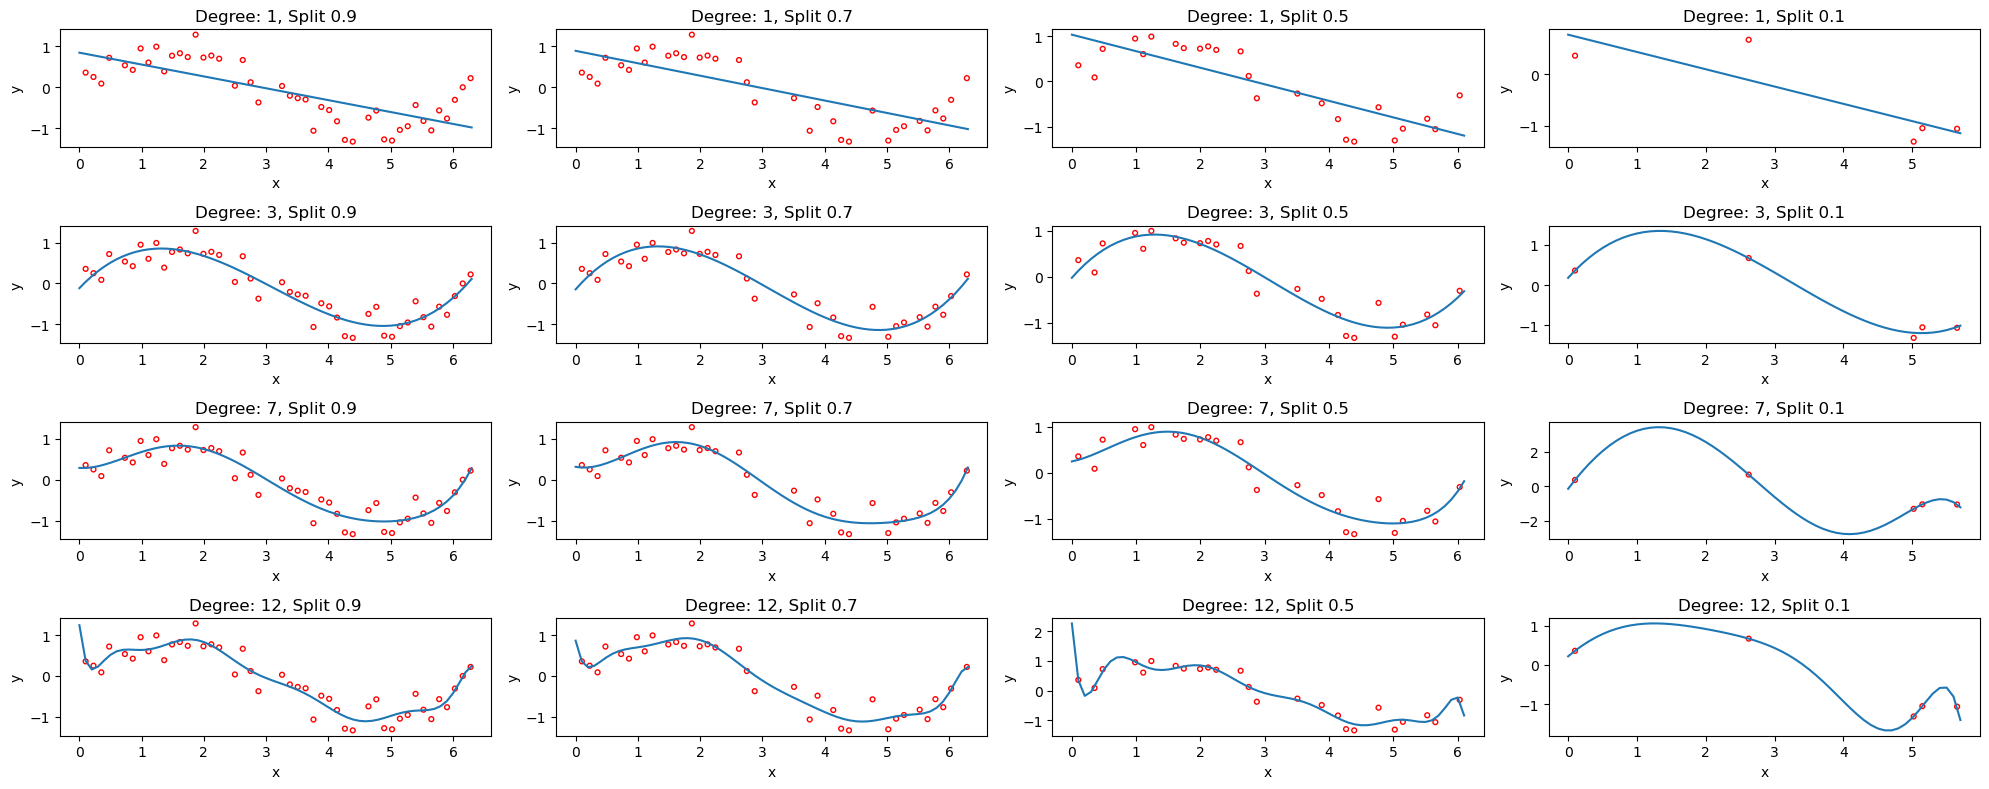

In [107]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]
#x, y = load_data() # heb je net zelf gezet, omdat je error kreeg dat x bij train_test_split_demo niet bestaat.

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w= train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [108]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    # w = np.linalg.inv(tx.T@tx + 2*len(tx)*lambda_*np.identity(len(tx))) @ tx.T@y
    w=np.linalg.inv(tx.T@tx + 2*tx.shape[0]*lambda_*np.eye((tx.shape[1]))) @ tx.T@y
    
    return w 

In [109]:
test(ridge_regression)

✅ Your `ridge_regression` passed 2 tests.


In [110]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    x_tr, x_te, y_tr, y_te=split_data(x, y, ratio, seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    x_tr_poly = build_poly(x_tr, degree)
    x_te_poly = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        w_tr = ridge_regression(y_tr, x_tr_poly, lambda_)

        mse_tr_ = compute_loss(y_tr, x_tr_poly, w_tr)#you must use the weights you have obtained during the training phase!!!
        rmse_tr_ = np.sqrt(2*mse_tr_)
        rmse_tr.append(rmse_tr_)

        mse_te_ = compute_loss(y_te, x_te_poly, w_tr)
        rmse_te_ = np.sqrt(2*mse_te_)
        rmse_te.append(rmse_te_)
        # Inside your loop
        print(
            "proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, d=degree, l=float(lambda_), tr=float(rmse_tr[ind]), te=float(rmse_te[ind])
            )
        )

        print(x_tr_poly.shape)

    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
(25, 8)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
(25, 8)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
(25, 8)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
(25, 8)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
(25, 8)
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
(25, 8)
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
(25, 8)
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
(25, 8)
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
(25, 8)
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
(25, 8)
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
(25, 8)
proportion=0.5, degree=7, lambda

ValueError: x and y can be no greater than 2D, but have shapes (15,) and (15, 1, 1)

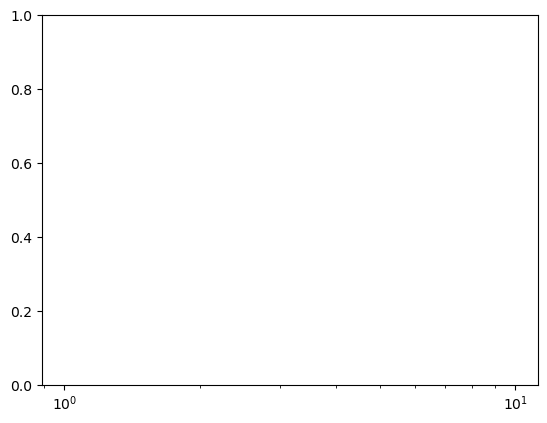

In [111]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)